In [1]:
import math
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy import stats, integrate
import pandas as pd
import pytz
import datetime as dt

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

import seaborn as sns

In [2]:
#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Read and manipulate psychopy and shimmer files 

In [3]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals



#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    
    float_array =[float(val) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df
    

## Time Domain HRV

In [4]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output


def remove_outliers_rri(r_peaks, sampling_freq = 256):
    
    # RR-intervals are the differences between successive peaks
    r_peaks_sec = r_peaks*1/sampling_freq
    r_peaks_msec = r_peaks_sec*1000

    r_peaks_diff=np.diff(r_peaks_msec)
    
    rr_corrected = r_peaks_diff.copy()

    rr_corrected[np.abs(zscore(r_peaks_diff)) > 3] = np.median(r_peaks_diff)
    
    return rr_corrected
    


def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
        
        
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [5]:
def plot_ecg_wf(sliced_ecg_df,r_peaks, nr_plots=3):
    starting_index_slcide_df= sliced_ecg_df.index[0]
    sampfrom = starting_index_slcide_df
    sampto = starting_index_slcide_df+256*time_offset*60
    
    rr_interval_cumm = []
    for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
        print(start)
        print(stop)
        # get sliced data of ECG
        #cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index <= stop)
        #sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]
        
        sliced_ecg_hrv = sliced_ecg_df["filtered"][(sliced_ecg_df.index >= start) & (sliced_ecg_df.index<= stop)]
        
        sliced_ecg_raw = sliced_ecg_df["heartrate"][(sliced_ecg_df.index >= start) & (sliced_ecg_df.index<= stop)]
        
        
        r_peaks_selected = [r_p for r_p in r_peaks if r_p >= start and r_p <= stop]
        
        plt.figure(figsize=(20, 15))

        plt.subplot(211)
        plt.title("ECG signal with found peaks")
        plt.plot(sliced_ecg_raw, label="ECG", color="#51A6D8", linewidth=1)
        #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
        #plt.plot(r_peaks_selected, np.repeat(0.3, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
        plt.legend(loc="upper right")
        plt.xlabel("Time (milliseconds)")
        plt.ylabel("Amplitude (arbitrary unit)")

        plt.subplot(212)
        plt.title('Filtered Signal')
        
        #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
        plt.plot(sliced_ecg_hrv, label="Filtered Signal", color="olive", linewidth=1)
        plt.plot(r_peaks_selected, np.repeat(0.3, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
        plt.legend(loc="upper right")
        plt.xlabel("Time (milliseconds)")
        plt.ylabel("Similarity (normalized)")
        
        

## Frequency Domain HRV

In [6]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [33]:

#psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP027_271123/Psychopy_data/VP027_271123_DigiRelax_Experiment_2023-11-27_15h58.18.227.csv"
#ecg_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp3/VP027_271123/Shimmer_data/2023-11-27_15.21.59_VP027_271123_SD_Session1/VP027_271123_Session1_Shimmer_6B1E_Calibrated_SD.csv"

psychopy_file_path = "/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp4_excluded_data/VP065_050124/Psychopy_data/VP065_050124_DigiRelax_Experiment_2024-01-05_14h41.28.548.csv"
ecg_file_path ="/home/muhammad/Desktop/Datasets/data_sony_digiRelax/wp4_excluded_data/VP065_050124/Shimmer_data/2024-01-05_14.19.39_VP065_050124_SD_Session1/VP065_050124_Session1_Shimmer_6B1E_Calibrated_SD.csv" 



event_interest_list_new = ["baseline_instruction_ts", "tsst_prep_ts", "tsst_pres_ts", "relaxation_prep_ts", "saliva_probe_4_ts", "saliva_probe_4_ts"]

#selected events
event_interest = event_interest_list_new[1]

#ä offset time in mins
time_offset = 5

sampling_freq = 256

nr_plots = 5

psychopy start time: 2024-01-05 14:49:34.031762+01:00
psychopy stop time: 2024-01-05 14:54:34.031762+01:00
ECG start time: 2024-01-05 14:49:34.032104+01:00
ECG stop time: 2024-01-05 14:54:34.028198+01:00
0
15360
15360
30720
30720
46080
46080
61440
61440
76800


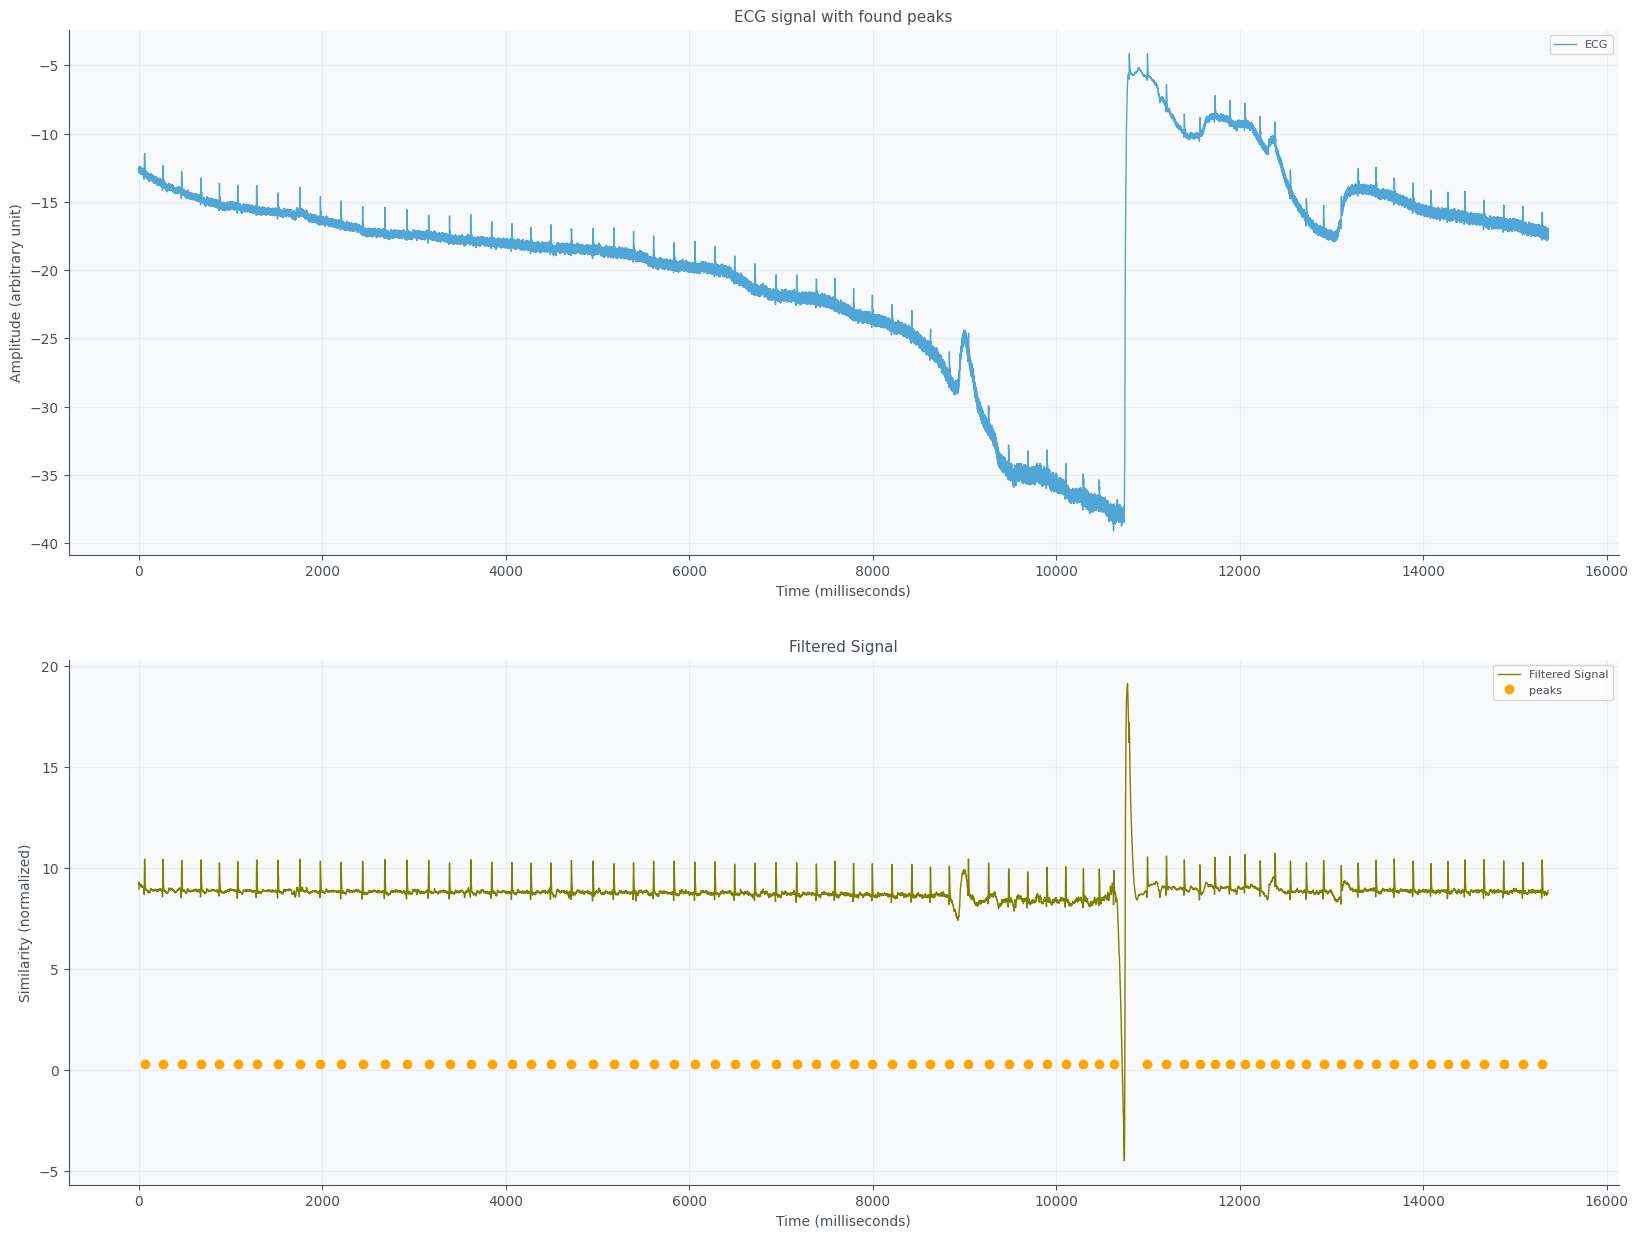

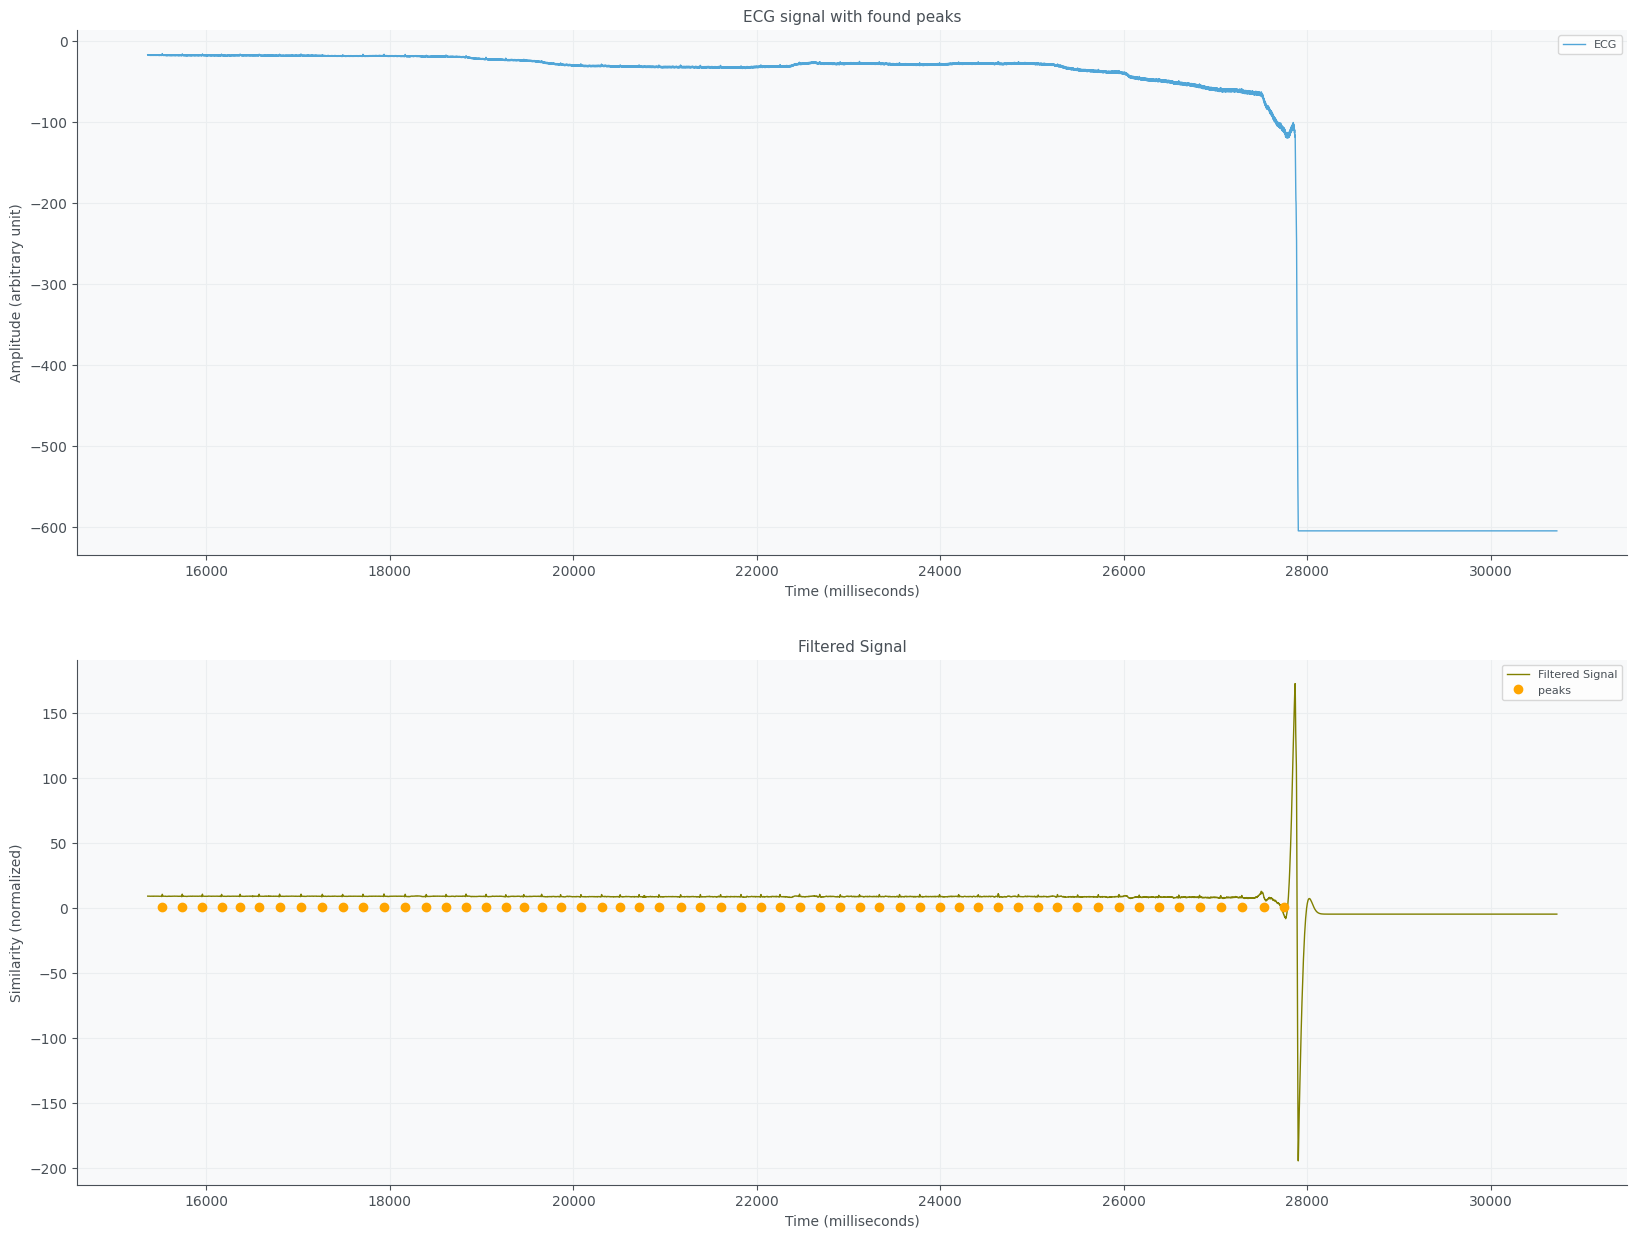

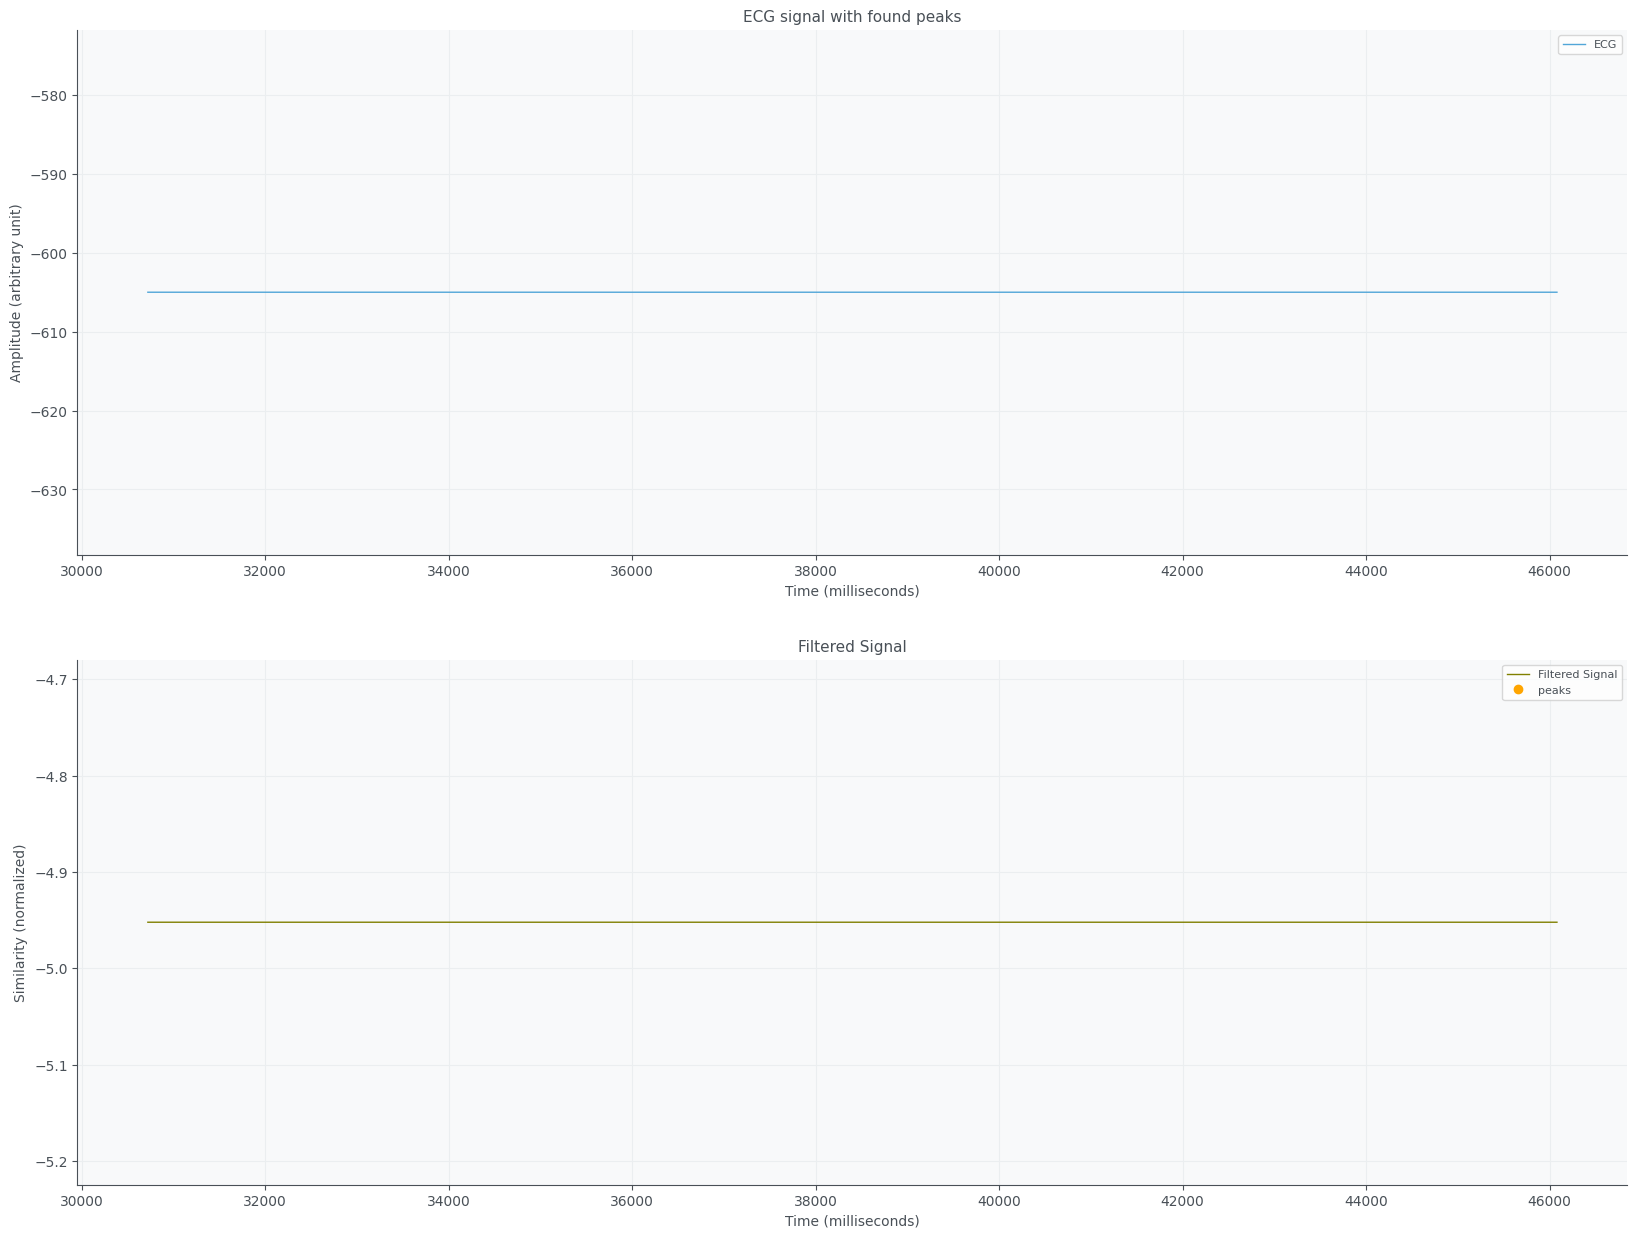

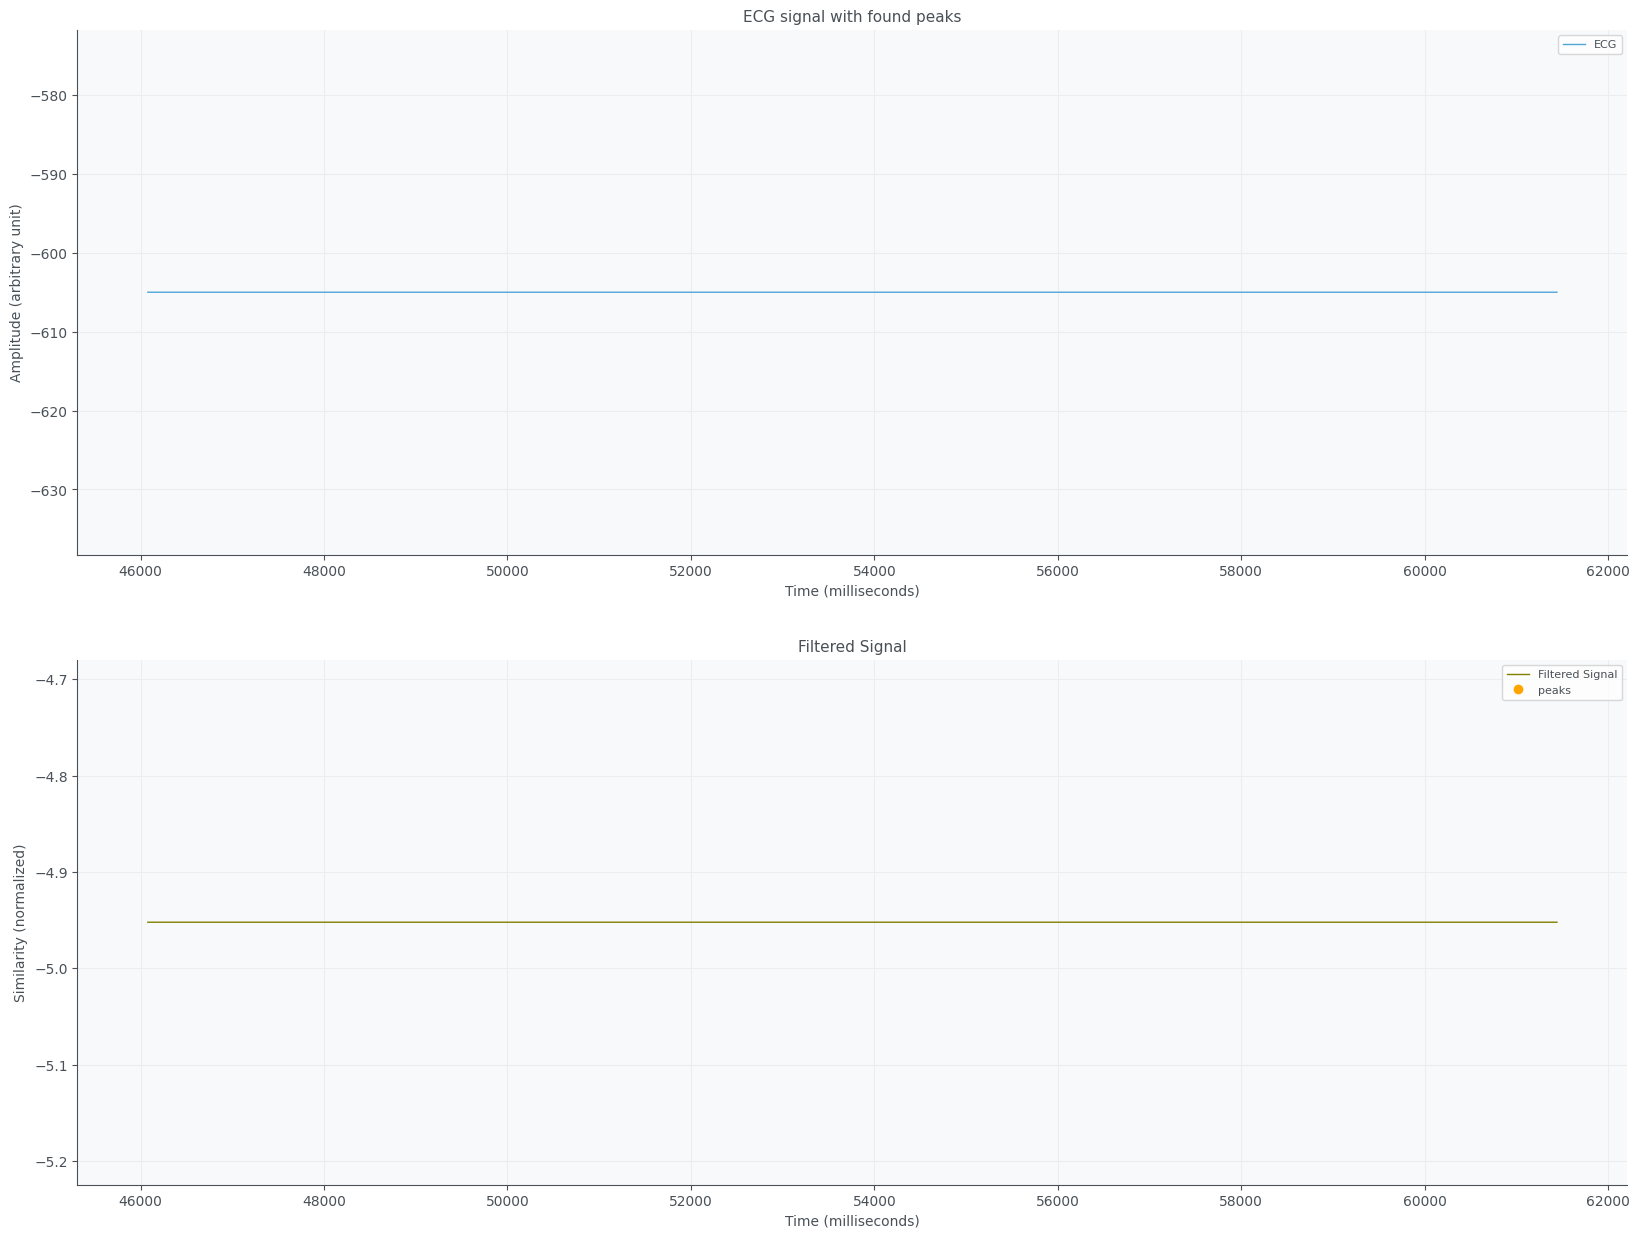

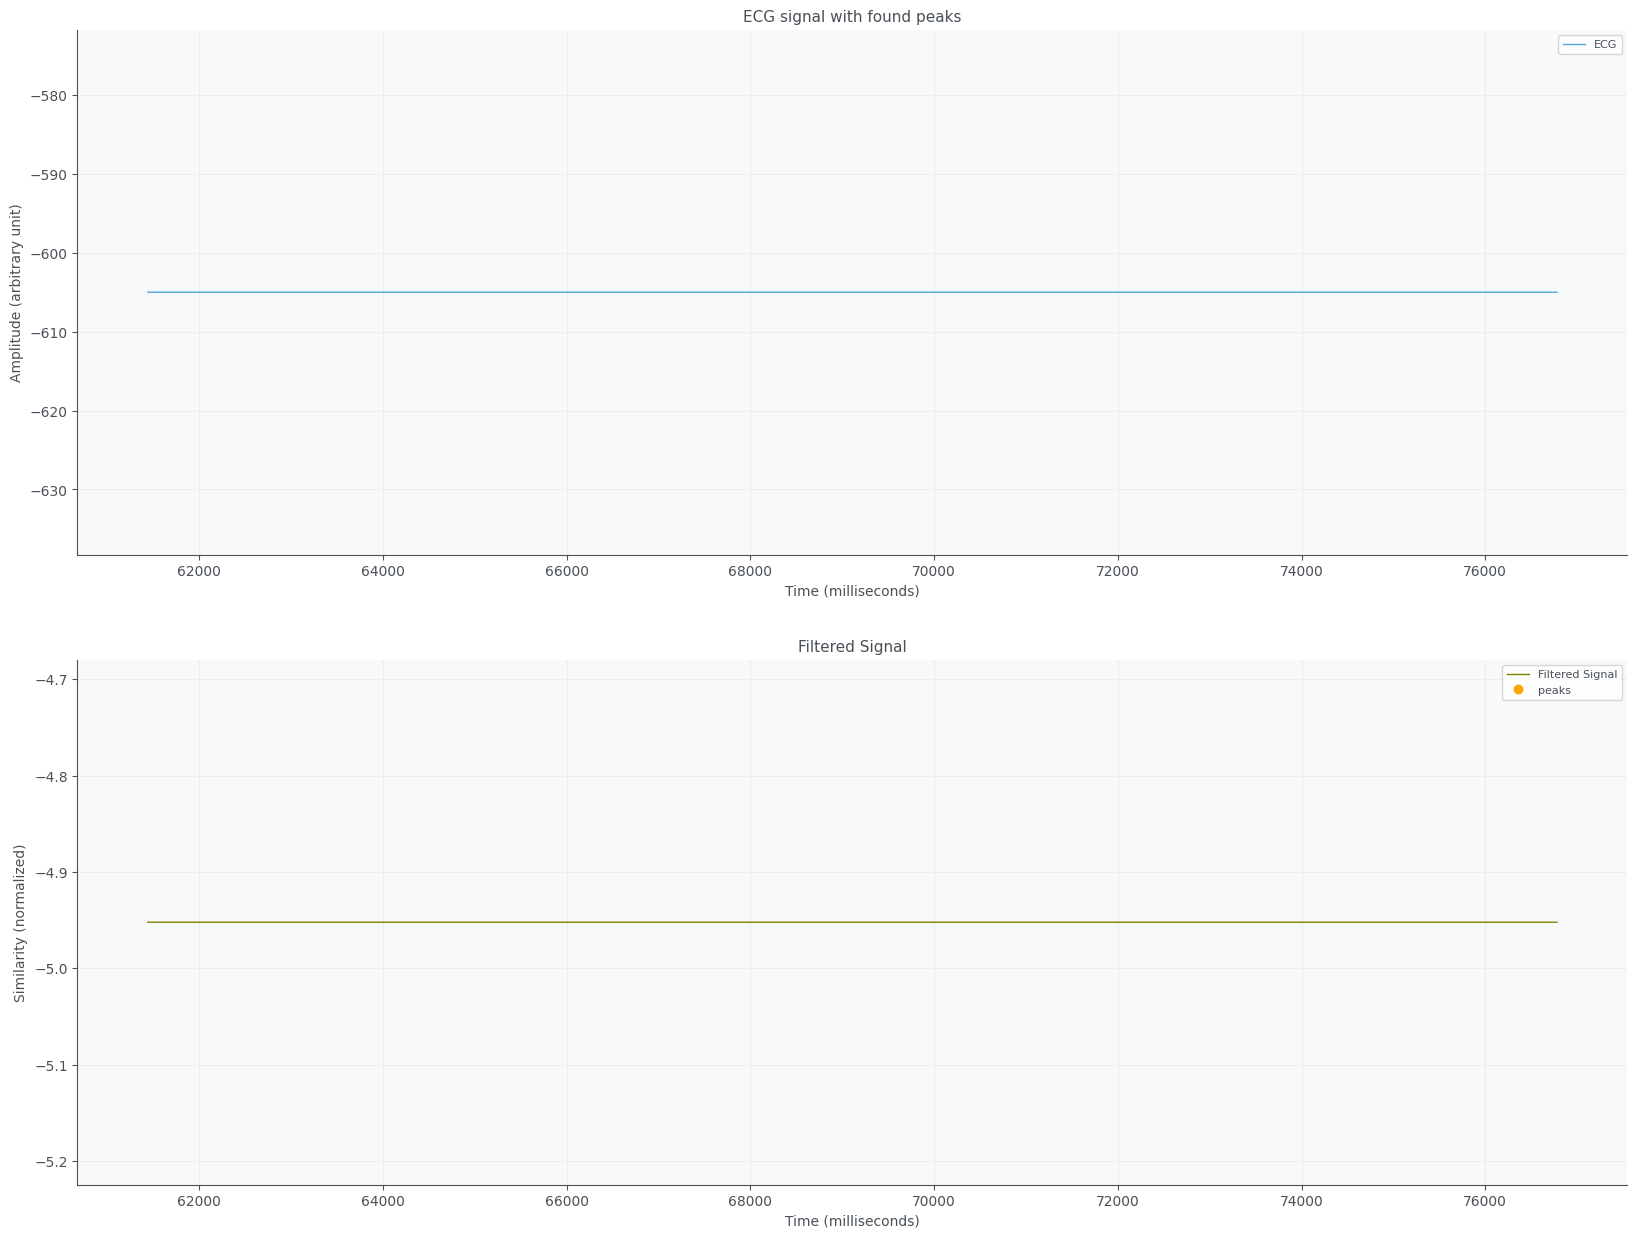

In [34]:

ecg_col_name = "Shimmer_6B1E_ECG_LA-RA_24BIT_CAL"
timestamp_shimmer_col_name = "Shimmer_6B1E_Timestamp_Unix_CAL"


psychopy_df = read_manipulate_psychopy(psychopy_file_path)
non_nan_timestamp=get_nonNan_list_psychopy(psychopy_df, event_interest)

start_timestamp = non_nan_timestamp[0]
stop_timestamp = get_offset_timestamp(start_timestamp, time_offset)


#print("psychopy start timestamp: " + str(start_timestamp))
#print("psychopy stop timestamp: " + str(stop_timestamp))

time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)
    
start_time = dt.datetime.fromtimestamp(start_timestamp, tz)
end_time  = dt.datetime.fromtimestamp(stop_timestamp, tz)

print("psychopy start time: "+str(start_time))
print("psychopy stop time: "+str(end_time))

###---------ECG------------------------------------
ecg_df = read_shimmer_sensor(ecg_file_path)

selected_ecg_df = ecg_df[[timestamp_shimmer_col_name, ecg_col_name]]
selected_ecg_df = selected_ecg_df.copy()
selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, timestamp_shimmer_col_name)


sliced_ecg_df=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp, stop_timestamp, timestamp_shimmer_col_name)
sliced_ecg_df=sliced_ecg_df.reset_index(drop=True)

start_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[0]
stop_time_hr = sliced_ecg_df[timestamp_shimmer_col_name].values[-1]

start_time_hr = dt.datetime.fromtimestamp(start_time_hr, tz)
end_time_hr  = dt.datetime.fromtimestamp(stop_time_hr, tz)

print("ECG start time: " + str(start_time_hr))
print("ECG stop time: " + str(end_time_hr))

sliced_ecg_df=sliced_ecg_df.copy()
sliced_ecg_df['heartrate'] = sliced_ecg_df[ecg_col_name]
sliced_ecg_df=col_from_str_float (sliced_ecg_df, "heartrate")

ecg_array = sliced_ecg_df["heartrate"].values

out = ecg.ecg(signal=ecg_array, sampling_rate=sampling_freq, show=False,interactive=False)

sliced_ecg_df["filtered"] = out["filtered"]

r_peaks = out["rpeaks"]

#r_peaks = detect_peaks(sliced_ecg_df["filtered"].values, threshold=0.3, qrs_filter=None)
plot_ecg_wf(sliced_ecg_df, r_peaks, nr_plots)

rr_corrected=remove_outliers_rri(r_peaks)


## R-Corrected

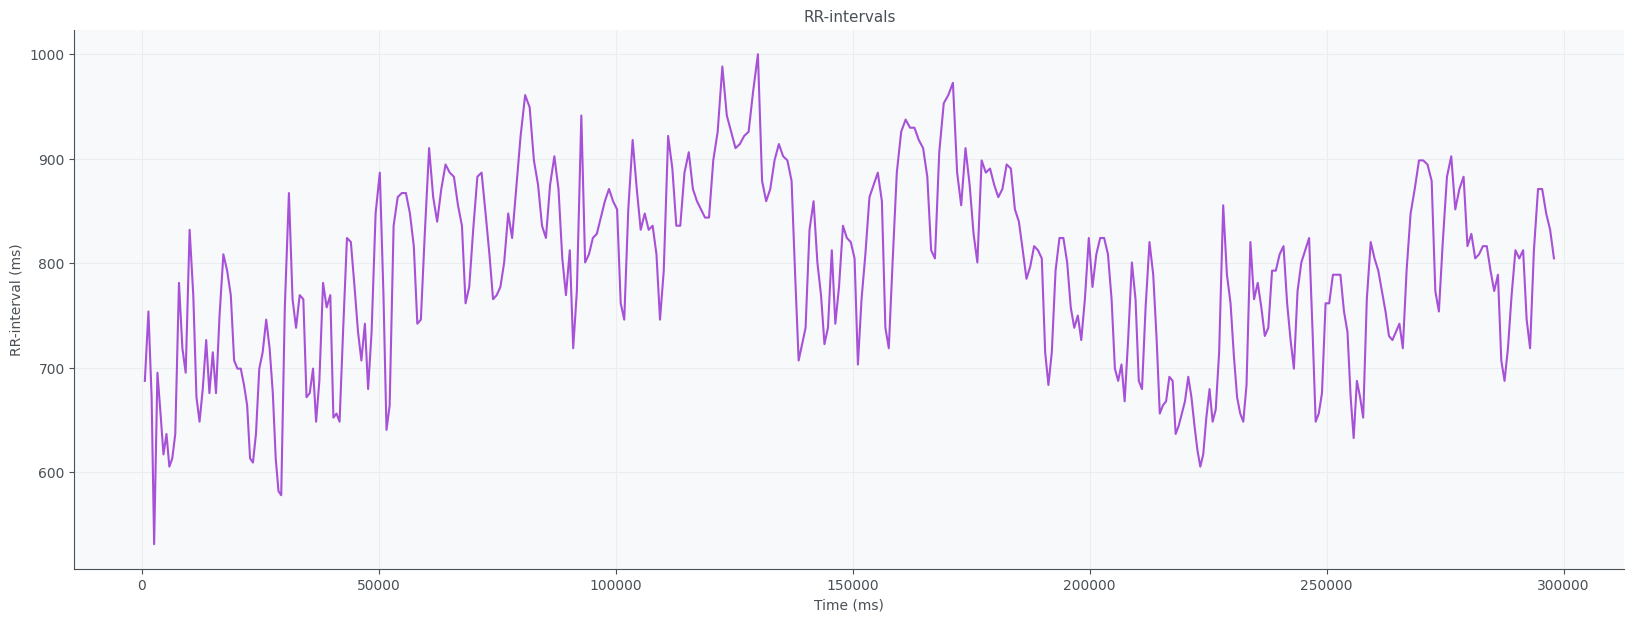

In [27]:
#r_peaks_sec=r_peaks*1/256
#r_peaks_msec = r_peaks_sec*1000
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")
plt.plot(np.cumsum(rr_corrected), rr_corrected, label="RR-interval", color="#A651D8")
plt.show()
#print(r_peaks_msec)

In [28]:
#rr = np.diff(r_peaks)
heart_rate = out["heart_rate"]

print("mean_IBI_msec:" + str(np.mean(rr_corrected)))
print("std_IBI_msec:" + str(np.std(rr_corrected)))

print("mean_heart_rate: " + str(np.mean(heart_rate)))
print("std_heart_rate: " + str(np.std(heart_rate)))

mean_IBI_msec:786.2075362796834
std_IBI_msec:87.94278419966074
mean_heart_rate: 77.31826508903907
std_heart_rate: 8.24250489218406


<Figure size 640x480 with 0 Axes>

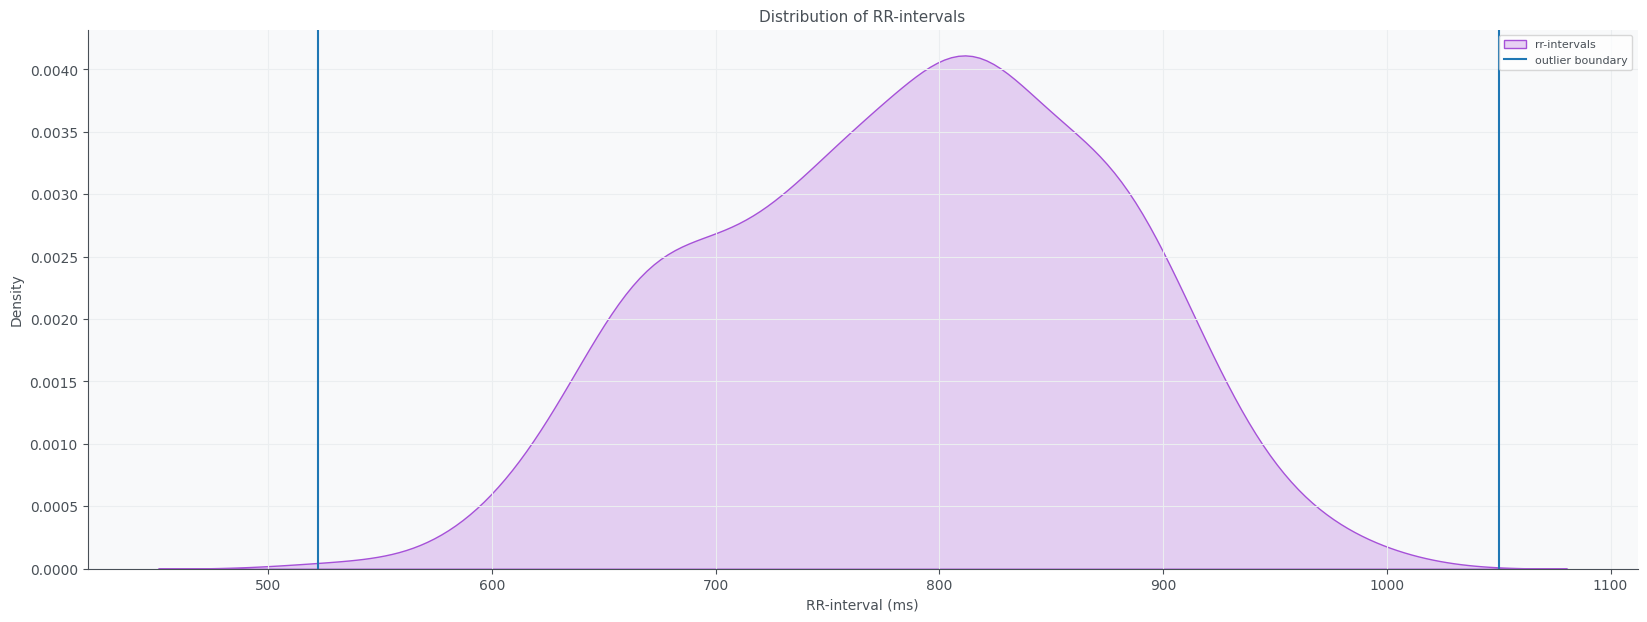

In [29]:
plt.figure()
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr_corrected, label="rr-intervals", color="#A651D8", shade=True)
    
    
outlier_low = np.mean(rr_corrected) - 3 * np.std(rr_corrected)
outlier_high = np.mean(rr_corrected) + 3 * np.std(rr_corrected)
plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
#plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
#plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

In [30]:
timedomain(rr_corrected)

{'Mean RR (ms)': 786.2075362796834,
 'STD RR/SDNN (ms)': 87.94278419966074,
 'Mean HR (beats/min)': 77.31826508903909,
 'STD HR (beats/min)': 9.04593064744911,
 'Min HR (beats/min)': 60.0,
 'Max HR (beats/min)': 112.94117647058823,
 'RMSSD (ms)': 51.46191161607666,
 'NNxx': 113,
 'pNNxx (%)': 29.815303430079155}

In [14]:
#rr_corrected

In [15]:
x = np.cumsum(rr_corrected)/1000
f = interp1d(x, rr_corrected, kind='cubic')

In [16]:
# sample rate for interpolation
fs = 4.0
steps = 1 / fs
# now we can sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)

## Frequency domain analysis

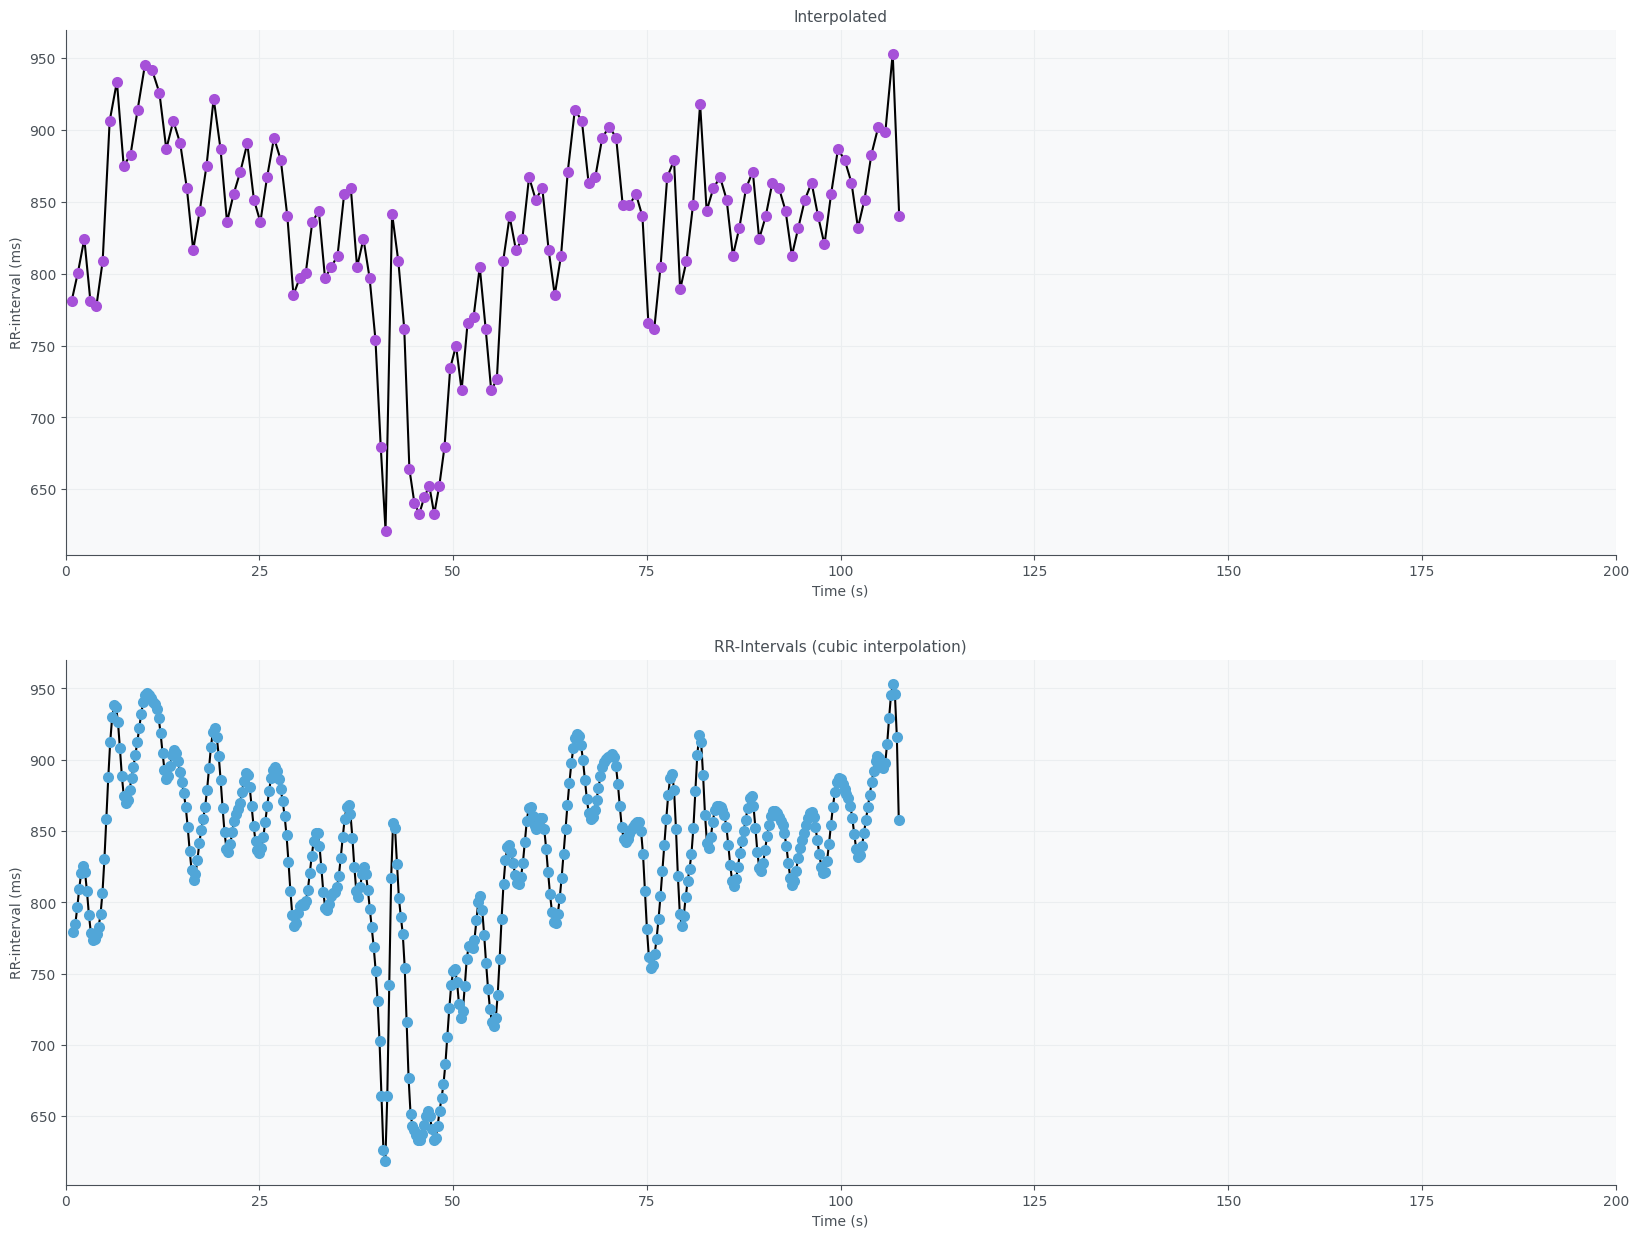

In [17]:
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x, rr_corrected, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 200)



plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx, rr_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 200)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [18]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 2354.35
- Power LF (ms2): 648.86
- Power HF (ms2): 889.30
- Power Total (ms2): 3892.51
- LF/HF: 0.73
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.25
- Fraction LF (nu): 42.18
- Fraction HF (nu): 57.82


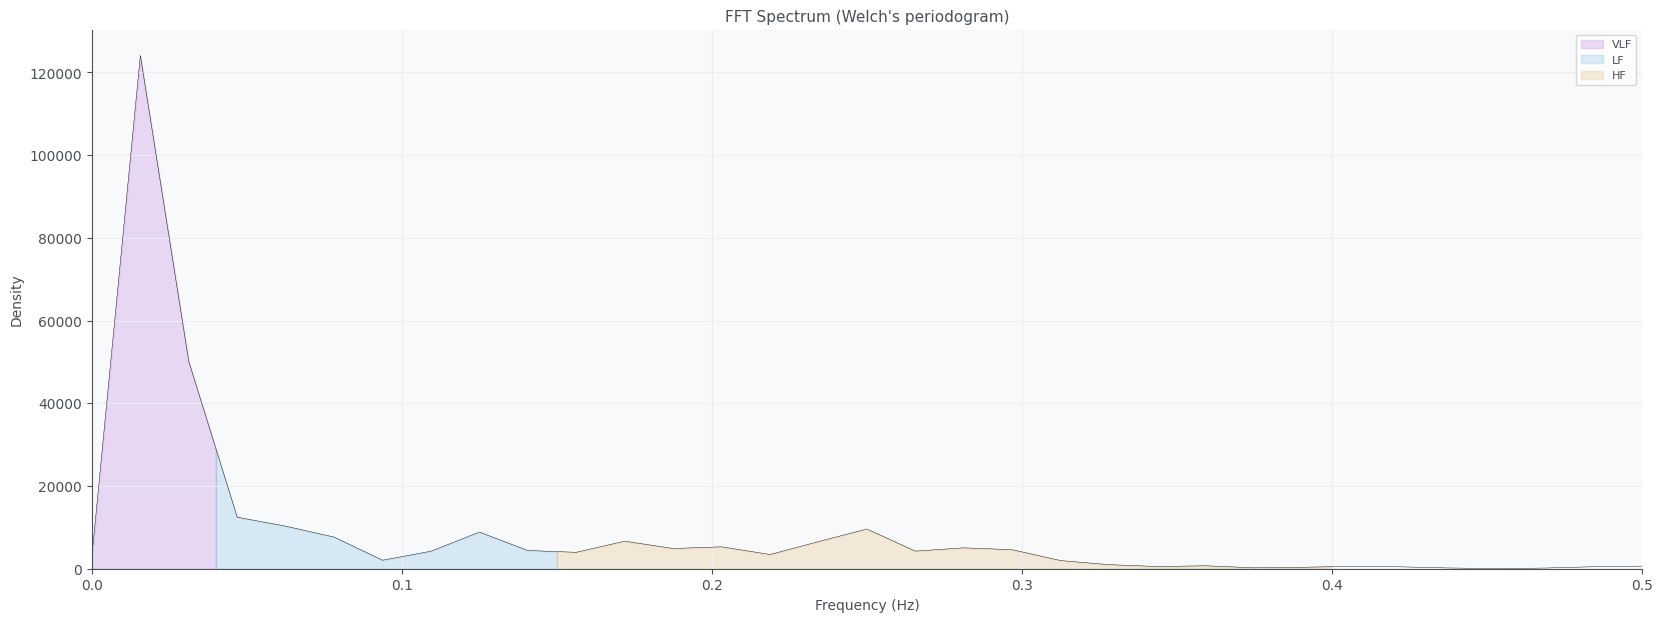

In [19]:
plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

In [20]:
peak_cumm = []
for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
    print(start)
    print(stop)
    # get sliced data of ECG
    cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index < stop)
    sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]

    # detect peaks
    
    peaks, similarity = detect_peaks(sliced_ecg_hrv, threshold=0.3)
    grouped_peaks=group_peaks(peaks)
    peak_cumm.extend(grouped_peaks)
    
    
    # plot similarity
    
    plt.figure(figsize=(20, 15))

    plt.subplot(211)
    plt.title("ECG signal with found peaks")
    plt.plot(sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
    plt.plot(peaks, np.repeat(0.6, peaks.shape[0]), label="peaks", color="orange", marker="o", linestyle="None")
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Amplitude (arbitrary unit)")
    
    plt.subplot(212)
    plt.title('Similarity with QRS template')
    #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.plot(similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
    plt.legend(loc="upper right")
    plt.xlabel("Time (milliseconds)")
    plt.ylabel("Similarity (normalized)")

NameError: name 'sampfrom' is not defined

In [67]:
rr_simple = np.diff(peak_cumm)
print("mean_rr_simple: "+ str(np.mean(rr_simple)*1/sampling_freq))
print("std_rr_simple: " + str(np.std(rr_simple)*1/sampling_freq))

mean_rr_simple: 0.7724281330749354
std_rr_simple: 0.04982307940336068


In [32]:
rr = np.diff(r_peaks)
heart_rate = out["heart_rate"]

print("mean_rr: "+ str(np.mean(rr)*1/sampling_freq))
print("std_rr: " + str(np.std(rr)*1/sampling_freq))
print("mean_heart_rate: " + str(np.mean(heart_rate)))
print("std_heart_rate: " + str(np.std(heart_rate)))

mean_rr: 0.8290879360465117
std_rr: 0.058415994230138886
mean_heart_rate: 72.71803788761945
std_heart_rate: 4.2151516906147934


In [10]:
import pandas as pd
import numpy as np

# create a dataframe
raw_data = {'first_name': ['Sam', 'Ziva', 'Kia', 'Robin', 'Kim'], 
         'degree': ["MBA", "MS", "Graduate", "Arts", "MS"],
         'nationality': ["USA", "India", "UK", "France", "Canada"],
         'age': [25, 29, 19, 21, 33],
         'grade':['A+',  'A', 'C', np.nan, 'B-']}

df = pd.DataFrame(raw_data, columns = ['first_name', 'degree','nationality',
         'age','grade'])
df

,first_name,degree,nationality,age,grade
0,Sam,MBA,USA,25,A+
1,Ziva,MS,India,29,A
2,Kia,Graduate,UK,19,C
3,Robin,Arts,France,21,NaN
4,Kim,MS,Canada,33,B-


In [13]:
df["first_name"][df['age'] > 28].values

array(['Ziva', 'Kim'], dtype=object)